## The plan

1. Get some data about which airports people fly between, and how many people fly.
1. Get some data about where those airports are, because people generally want to travel between cities, not airports
1. Join this data together, so we know which cities people are travelling between.
1. Get some data about how long train journeys take between those cities.
1. Identify which journeys would be suitable for high-speed sleeper services
1. Do some fancy visualisations.

In [345]:
# Installing libraries

# !pipenv install pandas
# !pipenv install ciso8601
# !pipenv install sqlalchemy 
# !pipenv install records
# !pipenv install seaborn
# !pipenv install chart_studio
!pipenv install geopy

Installing geopy…
Adding geopy to Pipfile's [packages]…
✔ Installation Succeeded 
Pipfile.lock (bb0b4e) out of date, updating to (fad228)…
Locking [dev-packages] dependencies…
Locking [packages] dependencies…
✔ Success! 
Updated Pipfile.lock (bb0b4e)!
Installing dependencies from Pipfile.lock (bb0b4e)…
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 76/76 — 00:00:30mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm


In [346]:
# Importing libraries

import ciso8601
import datetime
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import records
import requests
import seaborn
import sqlite3

from geopy.distance import geodesic
from sqlalchemy import create_engine
from urllib.request import urlretrieve

%config InlineBackend.figure_formats = ['svg']

First, we're going to need to download some data about air travel in Europe. [Wikipedia](https://en.wikipedia.org/wiki/List_of_busiest_passenger_air_routes#Europe) is a good place to start, but they only cover the busiest ten routes, so we'll have to go back to the [source data](https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&dir=data) from Eurostat.

In [ ]:
# Being lazy about this - just copied from the Eurostat website and let's make them into a nice list for retrieval

file_names = """avia_par_at.tsv.gz
 avia_par_be.tsv.gz
 avia_par_bg.tsv.gz
 avia_par_ch.tsv.gz
 avia_par_cy.tsv.gz
 avia_par_cz.tsv.gz
 avia_par_de.tsv.gz
 avia_par_dk.tsv.gz
 avia_par_ee.tsv.gz
 avia_par_el.tsv.gz
 avia_par_es.tsv.gz
 avia_par_fi.tsv.gz
 avia_par_fr.tsv.gz
 avia_par_hr.tsv.gz
 avia_par_hu.tsv.gz
 avia_par_ie.tsv.gz
 avia_par_is.tsv.gz
 avia_par_it.tsv.gz
 avia_par_lt.tsv.gz
 avia_par_lu.tsv.gz
 avia_par_lv.tsv.gz
 avia_par_me.tsv.gz
 avia_par_mk.tsv.gz
 avia_par_mt.tsv.gz
 avia_par_nl.tsv.gz
 avia_par_no.tsv.gz
 avia_par_pl.tsv.gz
 avia_par_pt.tsv.gz
 avia_par_ro.tsv.gz
 avia_par_se.tsv.gz
 avia_par_si.tsv.gz
 avia_par_sk.tsv.gz
 avia_par_tr.tsv.gz
 avia_par_uk.tsv.gz""".split("\n\xa0")

In [ ]:
# Just checking that everything is here

file_names

We'll download all the files first, so that we don't have to keep retrieving them.

In [ ]:
os.mkdir('eurostat_avia')
for file_name in file_names:
    urlretrieve(f"https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&downfile=data%2F{file_name}",
                   f"eurostat_avia/{file_name}")

In [ ]:
tables = []

for file_name in os.listdir('eurostat_avia'):
    path = os.path.join('eurostat_avia', file_name)
    with gzip.open(path, 'r') as f:
        tables.append(pd.read_csv(f, sep='\t'))

Now I can use the nice `concat` function to merge all these tables together. `concat` will handle all the business of matching up missing columns etc. by name.

In [ ]:
merged = pd.concat(tables, sort=True)

In [ ]:
merged

There are lots of weird marks in cells that have missing data - let's replace them all with NaN for consistency.

In [ ]:
merged.replace(': ', np.nan, inplace=True)

We're only really looking for one year's worth of data - let's see which one is the most complete.

In [ ]:
merged.count().tail(50)

Looks like there are some issues with some missing data. Let's go for the 2017 data.

In [ ]:
merged[['unit,tra_meas,airp_pr\\time', '2017 ']]

First, let's make a copy and get rid of all the other columns. The data looks reasonably good, although there are some missing bits, and the first column is quite messy and will need some unpacking.

In [ ]:
clean = merged[['unit,tra_meas,airp_pr\\time', '2017 ']].copy()

In [ ]:
clean['unit'], clean['tra_meas'], clean['route'] = clean['unit,tra_meas,airp_pr\\time'].str.split(",", n = 3).str

Now we'll get rid of all the rows with NaN in them.

In [ ]:
clean.dropna(inplace=True)

In [ ]:
clean

This is looking a lot better, but the route column still needs a bit of unpacking. We'll use the same technique again.

In [ ]:
clean['orig_state'], clean['orig_airp'], clean['dest_state'], clean['dest_airp'] = clean['route'].str.split("_", n = 4).str

In [ ]:
clean

This is looking a lot better! Let's do a bit more cleaning. We can get rid of some of the columns we don't need, cast the numbers to an `int32`, we can rename some columns, and we're only going to look at the PAS_CRD (passengers carried) data. It probably doesn't matter too much which set of data we use, but we should only use one.

In [ ]:
clean = clean.astype({'2017 ': 'int32'})

clean = clean[clean['tra_meas']=='PAS_CRD'].sort_values(by='2017 ')

clean = clean[['2017 ', 'orig_state', 'orig_airp', 'dest_state', 'dest_airp']]

clean = clean.rename(columns={'2017 ': 'pas_crd'})

In [ ]:
clean

This is better still, and much more like what we're looking for. We can spot another couple of problems though. Firstly, there are flights going way outside of Europe (EGLL-KJFK is Heathrow-JFK, and EGLL-OMDB is Heathrow-Dubai). So we'll need to remove those.

First step is to get a list of the country codes in Europe - I've taken the EU+EFTA ones from [here](https://ec.europa.eu/eurostat/statistics-explained/index.php/Tutorial:Country_codes_and_protocol_order#Codes.2C_names_and_protocol_order_of_European_Union_.28EU.29_Member_States), excluding Iceland due to its geographic location.

In [ ]:
country_codes = """BE
BG
CZ
DK
DE
EE
IE
EL
ES
FR
HR
IT
CY
LV
LT
LU
HU
MT
NL
AT
PL
PT
RO
SI
SK
FI
SE
UK
LI
NO
CH""".split("\n")

In [ ]:
country_codes = pd.Series(country_codes, name='dest_state')

In [ ]:
clean = pd.merge(clean, country_codes, how='inner', on='dest_state')

In [ ]:
clean

In [ ]:
clean.sort_values(by='pas_crd', inplace=True)
clean

This is looking pretty good! The US and Dubai fligts are gone, and we're back to Madrid-Barcelona as the busiest air route in our dataset. Just one slight problem - everything seems to be in the dataset twice, once in each direction! We'd better fix this with a slightly ugly solution found [on StackOverflow](https://stackoverflow.com/questions/24676705/pandas-drop-duplicates-if-reverse-is-present-between-two-columns/24680568)...

In [ ]:
clean['check_string'] = clean.apply(lambda row: ''.join(sorted([row['orig_airp'], row['dest_airp']])), axis=1)


In [ ]:
clean

In [ ]:
clean = clean.drop_duplicates('check_string')

In [ ]:
clean = clean.drop('check_string', axis=1)

The direction of each route is now arbitrary, but I'm not too concerned about that. We now have a clean route and we're looking at around 3660 rows - just over half what we had before removing the duplicates, which seems reasonable.

Feels to me like it's time for a map! Let's look at the top 30 routes. I'm going to use the brilliant [Great Circle Mapper](gcmap.com) because I don't feel like coding any visualisations at this stage...

In [ ]:
clean.replace(['EG99', 'LI99'], np.nan, inplace=True)
clean.dropna(inplace=True)

In [90]:
print(",".join([f"{row.orig_airp}-{row.dest_airp}" for row in clean.tail(30).itertuples(index=False)]))

NameError: name 'clean' is not defined

## From airport codes to cities...

So this is all looking lovely - with one slight problem - all those codes don't make a lot of sense to us, and won't work for the rail search engines either. So we need a dataset to match these to city names - like [this one](http://ourairports.com/data/airports.csv).

In [332]:
airport_codes = pd.read_csv("airports.csv")

In [336]:
airport_codes = airport_codes[['name', 'municipality', 'ident', 'latitude_deg', 'longitude_deg']]
airport_codes
airport_codes.to_sql('airports', con=engine)

Nice! The `municipality` field looks pretty good for what we're looking for - let's just look at one that we know, which should return "London".

In [ ]:
airport_codes[airport_codes['ident']=='EGKK']['municipality']

Looks good! Let's go ahead and merge these. We'll need to do two merges, because we've got two airport codes for each row of data.

In [ ]:
merged = pd.merge(clean, airport_codes, how='left', left_on='orig_airp', right_on='ident')
merged.rename(columns={'name': 'orig_name', 'municipality':'orig_city'}, inplace=True)
merged.drop(columns=['ident'], inplace=True)

merged = pd.merge(merged, airport_codes, how='left', left_on='dest_airp', right_on='ident')
merged.rename(columns={'name': 'dest_name', 'municipality':'dest_city'}, inplace=True)
merged.drop(columns=['ident'], inplace=True)

merged

This is looking great, but as you'd expect, there's still more cleaning to do. That slash in `Toulouse/Blagnac` is going to confuse things later - let's see if that's part of a wider problem.

In [ ]:
merged[merged['dest_city'].str.find('/')>0]

101 rows - let's not try and deal with it manually! Looks like the first name in the group is probably the best one to use. There's also a similar issue with brackets - we'll fix them both at once.

In [ ]:
merged['dest_city'], _ = merged['dest_city'].str.split('(', n=1).str
merged['orig_city'], _ = merged['orig_city'].str.split('(', n=1).str
merged['dest_city'], _ = merged['dest_city'].str.split('/', n=1).str
merged['orig_city'], _ = merged['orig_city'].str.split('/', n=1).str

In [ ]:
merged

Before we go any further, I'm going to dump the DataFrame into a SQLite database. This will make it easier to add more values later on, without having to hold everything in-memory.

In [178]:
engine = create_engine('sqlite:///air.db')

In [ ]:
merged.to_sql('merged', con=engine)

## Rail data

We're in a pretty good position in relation to the flight passenger statistics - we've now got the city pairs matched to annual passengers carried. Now, let's go off and search for some rail data.

The HAFAS data is pretty much the best dataset for long-distance train routes across Europe - it powers the Deutsche Bahn journey planner, among many others. Luckily for us, open APIs seem to be available (albeit with only third-party documentation!) There are some great tools though - like [hafas-client](https://github.com/public-transport/hafas-client). I tried getting the REST API library to work, but couldn't manage it - so I've set up a simple implementation of the JavaScript library at `codesandbox.io` - we're essentially using a (very!) simple REST API to interface between this Python code and the wonderful JavaScript code which has already been developed.

First, let's set up a couple of simple python functions that will make it really easy for us to make requests to our API... 

In [277]:
def locations(search):
    r = requests.get("https://2v8gm.sse.codesandbox.io/locations", params={"search":search}).json()
    try:
        idx = r[0]['id']
        lat, lon = r[0]['location']['latitude'], r[0]['location']['longitude']
        return idx, lat, lon
    except KeyError:
        return None, None, None
    
def journey(origin, dest):
    try:
        r = requests.get("https://2v8gm.sse.codesandbox.io/journey", params={"from": origin, "to": dest}).json()
    except json.JSONDecodeError:
        return None
    return r

Let's do a simple test to make sure that this is working...

In [ ]:
locations("Paris")

In [ ]:
locations("Munich")

Looks good! Time for a test of the `journey` endpoint...

In [ ]:
e = journey(locations("Paris")[0], locations("Munich")[0])

In [ ]:
e

Pretty good, although this will need some work to unpack! It's also probably a good idea not to attempt to make three web requests in one line of code - this will make debugging difficult. We'll take a slightly different approach later when we're collecting data in bulk.

What we're really interested in from this data is the time taken. I'm interested in seeing this data for each leg, because we can then calculate the total journey length, not getting caught up in the vagaries of scheduling.

In [ ]:
leg_times = [(x['departure'], x['arrival']) for x in e[0]['legs']]
leg_times

That's the kind of data we're looking for. Just need to go from ISO8601 strings to something more useful.

In [ ]:
leg_times = [ciso8601.parse_datetime(x[1]) - ciso8601.parse_datetime(x[0]) for x in leg_times]

total_time = sum([x.seconds for x in leg_times])

total_time

It looks like we've got most of the way to what we need. At this point I'm going to move away from `pandas` for a bit, because pandas stores everything in memory, which will make things difficult as I now want to make a lot of requests and update rows one at a time. This is especially important if you're doing this on a train with a dodgy internet connection (like I am now!). So, we'll use a database instead and the `sqlite3` library to run queries against it.

### Another mini-plan:
- make all requests from bahn-hafas
- put all responses in db
- read responses from db and do processing
- do some visualisation

In [ ]:
con = sqlite3.connect("air.db")

In [ ]:
cur = con.cursor()

In [ ]:
for row in cur.execute("SELECT * FROM merged ORDER BY pas_crd LIMIT 5;"):
    print(row)

In [ ]:
for x in result:
    print(x)
    
result.close()

In [ ]:
cur.execute("""CREATE TABLE cities
(
    name TEXT,
    id TEXT,
    lon TEXT,
    lat TEXT
);""")
cur.execute("""CREATE UNIQUE INDEX cities_name_uindex ON cities (name);""")

In [ ]:
cur.execute("INSERT INTO cities SELECT dest_city, NULL FROM merged UNION SELECT orig_city, NULL FROM merged;")

We can reduce how many requests we're making to the Hafas API by doing this. We need to make sure that we use the `fetchall()` method because otherwise, we're attempting to modify the table as we're working on it, which doesn't seem to work.

In [168]:
cities = cur.execute("SELECT name FROM cities WHERE id IS NULL ORDER BY name DESC;").fetchall()

In [169]:
for city in cities:
    print(idx, lat, lon)
    idx, lat, lon = locations(city[0])
    cur.execute("UPDATE cities SET id = ?, lat = ?, lon = ? WHERE name = ?;", (idx, lat, lon, city[0]))
    con.commit()

5200016 43.197968 27.911246
7400106 56.87689 14.806807
8602867 55.009498 8.802022
2496001 54.670236 25.282908
9400662 40.919131 -8.527175
7122308 42.234397 -8.713468
8196001 48.207037 16.341553
8300120 45.42866 10.982742
8396008 45.444427 12.315491
7166014 40.155165 -2.408245
5200016 43.197968 27.911246
8003438 47.917107 11.759464
7100003 41.641972 -4.727004
7103216 39.458015 -0.381762
2005700 61.028405 42.41392
8300991 43.353032 10.470159
1000046 63.097578 21.621736
7400101 63.830127 20.267053
1000101 60.454012 22.252833
7600043 63.436327 10.39891
728767 52.557204 13.373171
8300107 45.657408 13.770431
8300130 45.6597 12.245133
8300340 38.017278 12.519304
8700161 47.389459 0.693787
8700065 43.611409 1.453942
8700108 43.12841 5.929599
7601513 59.165678 10.26649
8396006 45.067428 7.672976
8300386 41.961925 12.805035
5300050 45.750662 21.207522
8005858 53.644522 9.813713
None None None
8700104 43.240272 0.069532
1000038 61.499332 23.773385
2600080 59.440056 24.736867
974336 51.139704 13.5

Time for a quick visualisation!

In [318]:
cities = pd.read_sql('cities', con=engine)
cities = cities.astype({'lon': float, 'lat': float})
cities.dropna(inplace=True)
cities.reset_index(inplace=True)

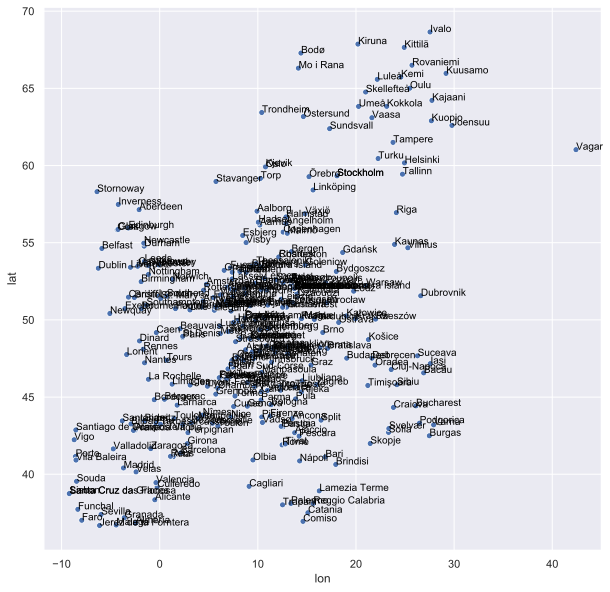

In [319]:
seaborn.set()
plt.figure(figsize=(10,10))
scatter = seaborn.scatterplot(x=cities.lon, y=cities.lat)

for line in range(0,cities.shape[0]):
     scatter.text(cities.lon[line]+0.02, cities.lat[line], 
     cities.name[line], horizontalalignment='left', 
     size='small', color='black', weight='normal')

Well, that certainly looks like Europe.

Let's try a fancier visualisation...

In [328]:
fig = go.Figure(go.Scattermapbox(
        lat=cities['lat'],
        lon=cities['lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            opacity=0.5
        ),
        hovertext=cities['name'],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=MAPBOX_ACCESS_TOKEN,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=49,
            lon=6
        ),
        pitch=0,
        zoom=4
    )
)

fig.show()

In [ ]:
cur.execute("ALTER TABLE merged ADD orig_db_id TEXT NULL;")
cur.execute("ALTER TABLE merged ADD dest_db_id TEXT NULL;")

In [170]:
cur.execute("UPDATE merged SET orig_db_id = (SELECT id FROM cities WHERE name = merged.orig_city);")
cur.execute("UPDATE merged SET dest_db_id = (SELECT id FROM cities WHERE name = merged.dest_city);")

In [171]:
con.commit()

Now, we've probably got most of the data we need and it's almost time for a bit of initial visualisation. But first, we need to grab those all-important journey times...

In [278]:
while True:
    for row in cur.execute("SELECT * FROM merged WHERE NOT orig_db_id IS NULL AND NOT dest_db_id IS NULL AND journey_results IS NULL ORDER BY pas_crd DESC LIMIT 5;").fetchall():
        print(f"Making request for {row[11]}, {row[12]}")
        result = journey(row[11], row[12])
        print("Request done...")
        cur.execute("UPDATE merged SET journey_results = ? WHERE orig_db_id = ? AND dest_db_id = ?;", (json.dumps(result), row[11], row[12]))
        con.commit()

Making request for 8530079, 8796001
Request done...
Making request for 8396004, 7100064
Request done...
Making request for 1000094, 7496000
Request done...
Making request for 7096001, 8796001
Request done...
Making request for 8000261, 7096001
Request done...
Making request for 8592483, 8396004
Request done...
Making request for 7000756, 7096001
Request done...
Making request for 8196001, 8096021
Request done...
Making request for 8000261, 8096021
Request done...
Making request for 7096001, 7100045
Request done...
Making request for 8796001, 7100049
Request done...
Making request for 8000085, 8096003
Request done...
Making request for 728767, 7696001
Request done...
Making request for 8596008, 7096001
Request done...
Making request for 8396004, 8400561
Request done...
Making request for 9400008, 9400674
Request done...
Making request for 8396004, 7100049
Request done...
Making request for 8396004, 8796001
Request done...
Making request for 8400561, 6096001
Request done...
Making reques

Request done...
Making request for 8000261, 8000152
Request done...
Making request for 8000129, 8696001
Request done...
Making request for 7496000, 7400004
Request done...
Making request for 8800004, 7100045
Request done...
Making request for 7600160, 7696001
Request done...
Making request for 8000261, 9400674
Request done...
Making request for 8596008, 9400674
Request done...
Making request for 8700047, 8796002
Request done...
Making request for 8096021, 5196003
Request done...
Making request for 8000261, 1000094
Request done...
Making request for 5100069, 5196003
Request done...
Making request for 8096021, 1000094
Request done...
Making request for 7696001, 8096021
Request done...
Making request for 8096021, 6096001
Request done...
Making request for 5196007, 5196003
Request done...
Making request for 8796001, 8796002
Request done...
Making request for 8096021, 5496001
Request done...
Making request for 8796001, 7496000
Request done...
Making request for 8300281, 8396004
Request done

Request done...
Making request for 7100064, 7100051
Request done...
Making request for 8796002, 8400561
Request done...
Making request for 8796001, 7000756
Request done...
Making request for 7100051, 8800004
Request done...
Making request for 7096001, 7000496
Request done...
Making request for 5196001, 5196003
Request done...
Making request for 8300040, 8300039
Request done...
Making request for 5596001, 8800004
Request done...
Making request for 8696001, 7100049
Request done...
Making request for 8501008, 8396004
Request done...
Making request for 8196001, 8696001
Request done...
Making request for 7100045, 7000367
Request done...
Making request for 7096001, 5196001
Request done...
Making request for 7100064, 8571984


KeyboardInterrupt: 

In [87]:
cur.execute("ALTER TABLE merged ADD journey_time TEXT NULL;")
con.commit()

In [280]:
for row in cur.execute("SELECT * FROM merged WHERE NOT journey_results IS NULL;").fetchall():
    e = json.loads(row[10])
    total_times = []
    try:
        for i in e:
            leg_times = [(x['departure'], x['arrival']) for x in i['legs']]
            try:
                leg_times = [ciso8601.parse_datetime(x[1]) - ciso8601.parse_datetime(x[0]) for x in leg_times]
            except TypeError:
                break
            total_times.append(sum([x.seconds for x in leg_times]))
    except TypeError:
        pass
    print(total_times) # just to check that it's reading everything from the db OK
    try:
        total_time = min(total_times)
    except ValueError:
        total_time = None
    cur.execute("UPDATE merged SET journey_time = ? WHERE orig_db_id = ? AND dest_db_id = ?;", (total_time, row[11], row[12]))
    con.commit()

[54900, 57120, 52740]
[12300, 12360, 12480]
[24660, 26040, 24780]
[63660, 58740, 64620]
[51120, 46620, 50400]
[41340, 39720, 41280]
[60900, 52560, 60900]
[35880, 40140, 48540]
[62220, 59400, 42960]
[74040, 75120, 73440]
[4920, 4860, 4920]
[39540, 37320, 36360]
[71220, 71340, 81660]
[16140, 15960, 16680]
[]
[44580, 49260, 49620]
[40140, 40380, 40500]
[29880, 30360, 27540]
[81000, 83460, 83520]
[12300, 12360, 12480]
[39660, 39840, 57900]
[47160, 48300, 48600]
[63840, 64920, 62340]
[33660, 32760, 35760]
[50700, 31620]
[127980, 114180, 121440]
[12300, 12360, 12480]
[47160, 48300, 48600]
[35880, 40140, 48540]
[61260, 60360, 63300]
[48000, 51300, 45960]
[127980, 114180, 121440]
[33480, 36960, 38100]
[112500, 114240, 106800]
[32520, 38220, 30360]
[89280, 88680, 89580]
[12300, 12360, 12480]
[48120, 38040, 46260]
[28380, 38520, 38280]
[14220, 15240, 13560]
[100980, 104160, 117840]
[35880, 40140, 48540]
[32760, 36480, 33600]
[89160, 94500, 103380]
[53820, 50160, 53460]
[56520, 55860, 58140]
[794

[36480, 38220, 37440]
[7200, 8220, 8340]
[66780, 71160, 66780]
[7980, 7740, 8340]
[41340, 41520, 29460]
[39240, 39600, 49500]
[8040, 8580, 8040]
[102900, 103080, 107940]
[77520, 70680, 77220]
[15780, 15540, 15300]
[28320, 24960, 21960]
[75540, 86520, 74760]
[15540, 15540, 15360]
[102000, 101760, 101760]
[35160, 40920, 27000]
[15840, 15840, 16020]
[46020, 36180, 34080]
[56400, 57480, 57180]
[36120, 34860, 38160]
[]
[22440, 18660]
[12060, 11700, 12240]
[18300, 22800, 18360]
[67260, 67800, 69000]
[61020, 58800, 63660]
[61440, 62160, 65580]
[59640, 64680, 51300]
[40260, 47520, 30840]
[14220, 14640, 26880]
[33660, 33660, 36060]
[40680, 38880, 40680]
[38580, 40980, 36480]
[135840, 114660, 121440]
[42420, 45300, 33720]
[54060, 59340, 65340]
[16140, 16740, 17220]
[56400, 37320, 49920]
[82980, 89280, 82980]
[64920, 70140, 65100]
[36360, 51300, 39360]
[16140, 16740, 17220]
[75000, 80280, 75000]
[18660, 24600, 35640]
[40020, 39900, 33000]
[41100, 41280, 40500]
[12000, 11280, 21120]
[22020, 19260,

In [210]:
df

,name,id,lat,lon
0,Aalborg,8600004,57.043127,9.916486
1,Aarhus,8600087,56.150076,10.204995
2,Aberdeen,7000011,57.141856,-2.097434
3,Ajaccio,8307026,42.690240,13.755986
4,"Alajero, La Gomera Island",8011250,52.029825,13.721584
...,...,...,...,...
338,Årø,8011079,52.293245,14.064945
339,Örebro,7400129,59.278502,15.211618
340,Östersund,7400125,63.170651,14.636803
341,Ørsta,8005497,47.590646,7.868060


In [315]:
df = pd.read_sql('merged', con=engine)
df.dropna(inplace=True)
df = df.astype({'pas_crd': int, 'journey_time': int})
df['journey_time'] = df['journey_time']/3600
df['label'] = df['orig_city'] + "-" + df['dest_city']
df.reset_index(inplace=True)

In [335]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["journey_time"],
    y=df["pas_crd"],
    hovertext=df['orig_city'] + "-" + df['dest_city'],
    hoverinfo="text",
    showlegend=False,
    mode="markers"
))

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Journey time (hrs)",
            font=dict(
                family="Helvetica",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Air passengers carried (annual)",
            font=dict(
                family="Helvetica",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.update_yaxes(type="log")

Unfortunately, some problems are now becoming apparent - some of the journey times are much too low. We need to fix this by looking at the locations of the airports. We deliberately didn't want to look at journey times from airport locations, since most people travel from cities - but we can still make use of the airport data.

In [353]:
cur.execute("""DROP VIEW airport_locs""")
cur.execute("""CREATE VIEW airport_locs AS SELECT t1.name AS city, t1.lat AS city_lat, t1.lon AS city_lon,
               t2.latitude_deg AS airport_lat, t2.longitude_deg AS airport_lon FROM cities t1 INNER JOIN
               airports t2 ON t1.name=t2.municipality""")

In [354]:
con.commit()

In [355]:
df = pd.read_sql("SELECT * FROM airport_locs", con=engine)

In [373]:
df['distance'] = df.apply(lambda row: geodesic((row['city_lat'], row['city_lon']), (row['airport_lat'], row['airport_lon'])).kilometers, axis=1)

In [374]:
df.sort_values('distance', inplace=True)

In [365]:
df.drop_duplicates(subset=['city'], inplace=True)

In [375]:
fig = px.histogram(df, x="distance")
fig.show()

Clearly there are some issues here - some of the airport locations are thousands of km away from where they should be. Let's take a look at those that are located within 100 miles of their city...

In [376]:
fig = px.histogram(df[df["distance"]<100], x="distance")
fig.show()

Now all of these are within 40km, which seems reasonable. Let's take a quick look at that table...

In [377]:
df[df['distance']<100]

,city,city_lat,city_lon,airport_lat,airport_lon,distance
337,Amsterdam,52.308787,4.761487,52.308601,4.763890,0.165197
266,Baden-Baden,48.790392,8.190773,48.791943,8.185833,0.401855
577,Pula,44.879706,13.847199,44.876066,13.846447,0.408852
301,Southampton,50.950706,-1.362934,50.950298,-1.356800,0.433433
781,Luxembourg,49.599717,6.134392,49.603406,6.129105,0.560734
...,...,...,...,...,...,...
708,Cuneo,44.387898,7.535954,44.547001,7.623220,18.994566
406,Katowice,50.257512,19.017165,50.474300,19.080000,24.525572
426,Malmö,55.609231,13.00126,55.536305,13.376198,25.005581
407,Łódź,51.859659,19.762066,51.721901,19.398100,29.420762


In [378]:
df.to_sql('airport_dist', con=engine)

Some of these are really close! In the case of Amsterdam, it turns out that the Hafas API has returned Schiphol Airport as the station - but it doesn't really matter too much. We chose a good threshold though.

Now we need to remove all the locations with locations that are too long from the `cities` table.

In [ ]:
cur.execute("""update cities set id = (select null from airport_dist where cities.name = airport_dist.city and airport_dist.distance>100)""";
""")

In [381]:
pd.read_sql('SELECT * FROM merged', con=engine)

,index,pas_crd,orig_state,orig_airp,dest_state,dest_airp,orig_name,orig_city,dest_name,dest_city,journey_results,orig_db_id,dest_db_id,journey_time
0,0,10490,NO,ENVD,NO,ENAT,Vadsø Airport,Vadsø,Alta Airport,Alta,"[{""type"": ""journey"", ""legs"": [{""origin"": {""typ...",8300991,7171502,52740
1,1,11188,EL,LGLM,EL,LGTS,Limnos Airport,Limnos Island,Thessaloniki Macedonia International Airport,Thessaloniki,"[{""type"": ""journey"", ""legs"": [{""origin"": {""typ...",8011250,8005858,12300
2,2,11741,SE,ESOE,ES,GCTS,Örebro Airport,Örebro,Tenerife South Airport,Tenerife Island,None,7400129,None,None
3,3,12818,FR,LFRH,UK,EGSS,Lorient South Brittany (Bretagne Sud) Airport,Lorient,London Stansted Airport,London,"[{""type"": ""journey"", ""legs"": [{""origin"": {""typ...",8700207,7096001,24660
4,4,13447,NO,ENBN,NO,ENGM,Brønnøysund Airport,Brønnøy,Oslo Gardermoen Airport,Oslo,"[{""type"": ""journey"", ""legs"": [{""origin"": {""typ...",920993,7696001,58740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,3649,2009150,IT,LIRF,IT,LICC,Leonardo da Vinci–Fiumicino Airport,Rome,Catania-Fontanarossa Airport,Catania,"[{""type"": ""journey"", ""legs"": [{""origin"": {""typ...",8396004,8300307,23820
3650,3650,2087108,NO,ENVA,NO,ENGM,Trondheim Airport Værnes,Trondheim,Oslo Gardermoen Airport,Oslo,"[{""type"": ""journey"", ""legs"": [{""origin"": {""typ...",7600043,7696001,23700
3651,3651,2170589,FR,LFMN,FR,LFPO,Nice-Côte d'Azur Airport,Nice,Paris-Orly Airport,Paris,"[{""type"": ""journey"", ""legs"": [{""origin"": {""typ...",8700171,8796001,20640
3652,3652,2324695,FR,LFPO,FR,LFBO,Paris-Orly Airport,Paris,Toulouse-Blagnac Airport,Toulouse,"[{""type"": ""journey"", ""legs"": [{""origin"": {""typ...",8796001,8700065,15600


In [389]:
pd.read_sql('SELECT * FROM merged m LEFT JOIN airport_dist a ON m.orig_city=a.city', con=engine)

,index,pas_crd,orig_state,orig_airp,dest_state,dest_airp,orig_name,orig_city,dest_name,dest_city,...,orig_db_id,dest_db_id,journey_time,index,city,city_lat,city_lon,airport_lat,airport_lon,distance
0,0,10490,NO,ENVD,NO,ENAT,Vadsø Airport,Vadsø,Alta Airport,Alta,...,8300991,7171502,52740,399.0,Vadsø,43.353032,10.470159,70.065300,29.844700,3168.530316
1,1,11188,EL,LGLM,EL,LGTS,Limnos Airport,Limnos Island,Thessaloniki Macedonia International Airport,Thessaloniki,...,8011250,8005858,12300,673.0,Limnos Island,52.029825,13.721584,39.917099,25.236300,1610.919827
2,2,11741,SE,ESOE,ES,GCTS,Örebro Airport,Örebro,Tenerife South Airport,Tenerife Island,...,7400129,None,None,433.0,Örebro,59.278502,15.211618,59.223701,15.038000,11.635999
3,3,12818,FR,LFRH,UK,EGSS,Lorient South Brittany (Bretagne Sud) Airport,Lorient,London Stansted Airport,London,...,8700207,7096001,24660,465.0,Lorient,47.755374,-3.366154,47.749722,-3.378056,1.091520
4,4,13447,NO,ENBN,NO,ENGM,Brønnøysund Airport,Brønnøy,Oslo Gardermoen Airport,Oslo,...,920993,7696001,58740,366.0,Brønnøy,52.037151,8.639703,65.461098,12.217500,1508.949003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,3649,2009150,IT,LIRF,IT,LICC,Leonardo da Vinci–Fiumicino Airport,Rome,Catania-Fontanarossa Airport,Catania,...,8396004,8300307,23820,717.0,Rome,41.901868,12.470654,41.872900,12.563700,8.365972
3650,3650,2087108,NO,ENVA,NO,ENGM,Trondheim Airport Værnes,Trondheim,Oslo Gardermoen Airport,Oslo,...,7600043,7696001,23700,396.0,Trondheim,63.436327,10.39891,63.419894,10.385954,1.942629
3651,3651,2170589,FR,LFMN,FR,LFPO,Nice-Côte d'Azur Airport,Nice,Paris-Orly Airport,Paris,...,8700171,8796001,20640,482.0,Nice,43.704825,7.261765,43.689445,7.241667,2.354748
3652,3652,2324695,FR,LFPO,FR,LFBO,Paris-Orly Airport,Paris,Toulouse-Blagnac Airport,Toulouse,...,8796001,8700065,15600,470.0,Paris,48.861496,2.333681,48.882778,2.354444,2.814501


In [296]:
df = pd.read_sql('merged', con=engine)
df.dropna(inplace=True)
df = df.astype({'pas_crd': int, 'journey_time': int})
df = df[df['pas_crd']>0.8*10**6]
df['journey_time'] = df['journey_time']/3600
df = df[df['journey_time']<12]
df = df[df['journey_time']>7]

df['label'] = df['orig_city'] + "-" + df['dest_city']
df.reset_index(inplace=True)

In [313]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["journey_time"],
    y=df["pas_crd"],
    hovertext=df['orig_city'] + "-" + df['dest_city'],
    hoverinfo="text",
    showlegend=False,
    mode="markers"
))

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Journey time (hrs)",
            font=dict(
                family="Helvetica",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Air passengers carried (annual)",
            font=dict(
                family="Helvetica",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

In [292]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [322]:
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.express as px
MAPBOX_ACCESS_TOKEN = "pk.eyJ1Ijoia2VlbGFuZmgiLCJhIjoiY2sxODgzNjlpMWpnOTNkcGZ6MncxbGk1NyJ9.iHwe8a-cuG1m6EPZf9QszA"